# Análisis Estadístico CENTRO

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


# Cargar datos
centro = pd.read_csv("df_CENTRO_22_25.csv")
cols_contaminantes = ["PM10", "PM2.5", "O3", "NO2", "NO", "SO2"]
datos = centro[cols_contaminantes]

## Paso 1 - PCA

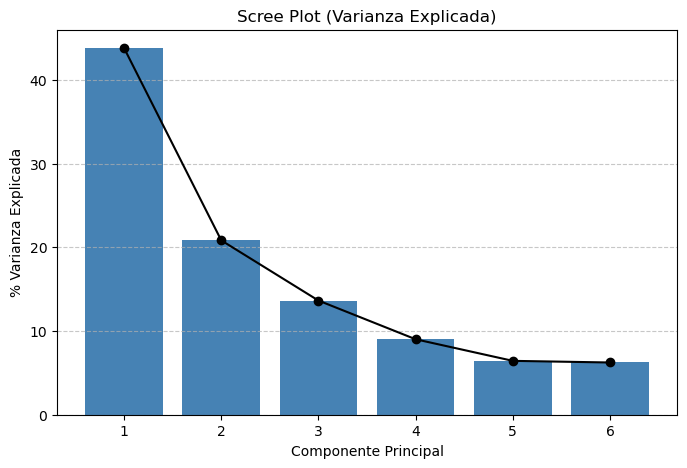

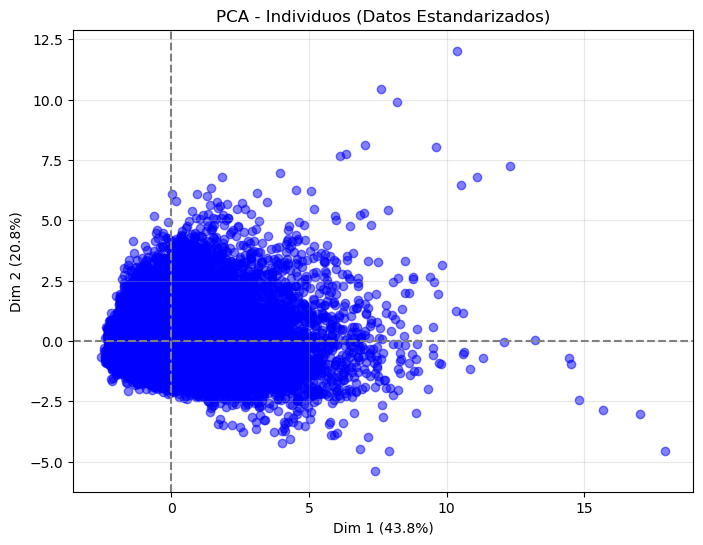

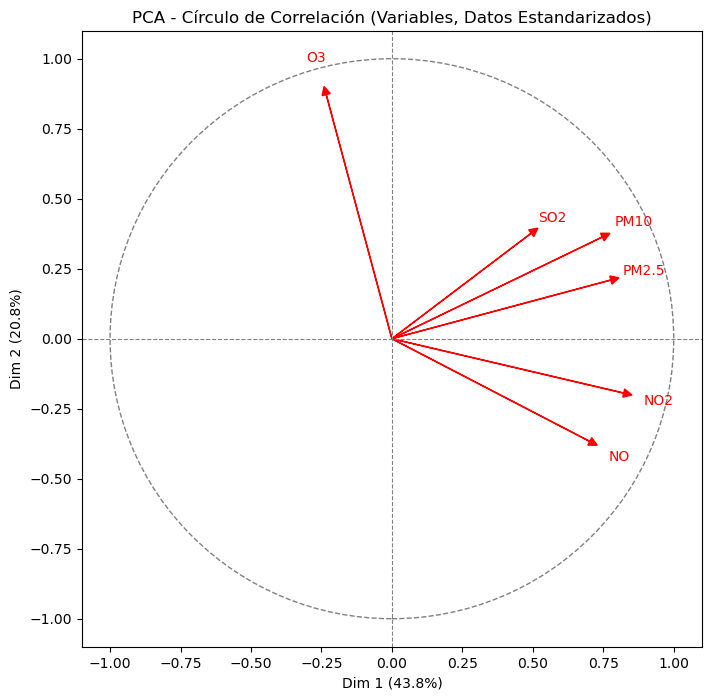

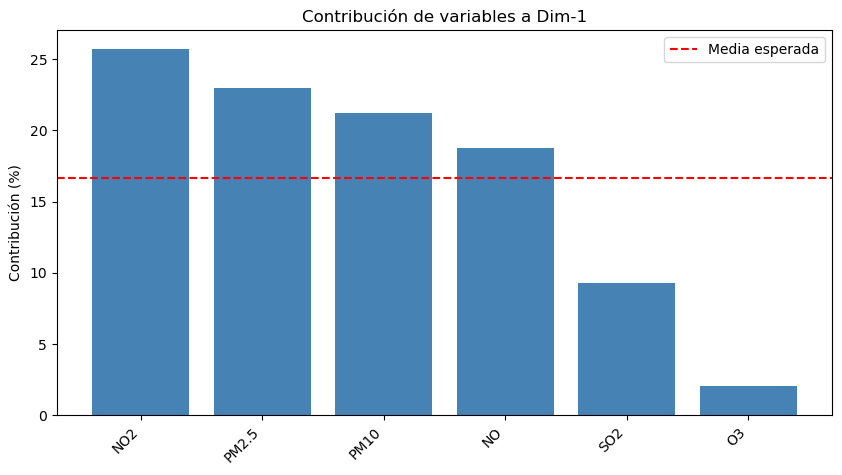

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# --- 1. Preparación de datos y estandarización ---
# Estandarizar los datos (media=0, var=1)
scaler = StandardScaler()
datos_std = scaler.fit_transform(datos)

# --- 2. PCA (ahora con datos estandarizados) ---
pca = PCA()
pca_ind = pca.fit_transform(datos_std)

# --- 3. Scree Plot (Varianza explicada) ---
plt.figure(figsize=(8, 5))
varianza_expl = pca.explained_variance_ratio_ * 100
plt.bar(range(1, len(varianza_expl) + 1), varianza_expl, color='steelblue')
plt.plot(range(1, len(varianza_expl) + 1), varianza_expl, marker='o', color='black')
plt.title('Scree Plot (Varianza Explicada)')
plt.xlabel('Componente Principal')
plt.ylabel('% Varianza Explicada')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# --- 4. Gráfica de Individuos ---
plt.figure(figsize=(8, 6))
plt.scatter(pca_ind[:, 0], pca_ind[:, 1], c='blue', alpha=0.5)
plt.xlabel(f'Dim 1 ({varianza_expl[0]:.1f}%)')
plt.ylabel(f'Dim 2 ({varianza_expl[1]:.1f}%)')
plt.title('PCA - Individuos (Datos Estandarizados)')
plt.axhline(0, color='grey', linestyle='--')
plt.axvline(0, color='grey', linestyle='--')
plt.grid(True, alpha=0.3)
plt.show()

# --- 5. Gráfica de Variables (Círculo de correlación) ---
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
features = datos.columns

plt.figure(figsize=(8, 8))
for i, feature in enumerate(features):
    plt.arrow(0, 0, loadings[i, 0], loadings[i, 1], 
              head_width=0.03, head_length=0.03, color='red')
    plt.text(loadings[i, 0]*1.15, loadings[i, 1]*1.15, feature, 
             color='red', ha='center', va='center')

plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.xlabel(f'Dim 1 ({varianza_expl[0]:.1f}%)')
plt.ylabel(f'Dim 2 ({varianza_expl[1]:.1f}%)')
plt.title('PCA - Círculo de Correlación (Variables, Datos Estandarizados)')
circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--')
plt.gca().add_artist(circle)
plt.axhline(0, color='grey', linestyle='--', linewidth=0.8)
plt.axvline(0, color='grey', linestyle='--', linewidth=0.8)
plt.grid(False)
plt.show()

# --- 6. Contribución de variables a la Dim-1 ---
contribs = (loadings[:, 0]**2)
contribs = 100 * contribs / contribs.sum()
indices_ordenados = np.argsort(contribs)[::-1]

plt.figure(figsize=(10, 5))
plt.bar(features[indices_ordenados], contribs[indices_ordenados], color='steelblue')
plt.axhline(100/len(features), color='r', linestyle='--', label='Media esperada')
plt.title('Contribución de variables a Dim-1')
plt.ylabel('Contribución (%)')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()

## Paso 2 - Agrupación

Creación de Grupos ($Y$), basado en PCA:
- $Y_1$ (Ozono): Columna O3.
- $Y_2$ (Material Particulado): Promedio de (PM10_std, PM2.5_std).
- $Y_3$ (Nitrógenos): Promedio de (NO_std, NO2_std).
- $Y_4$ (Azufre): Columna SO2 (o SO2_std).

In [3]:
# Estandarizar columnas relevantes en 'centro'
centro["PM10_std"] = (centro["PM10"] - centro["PM10"].mean()) / centro["PM10"].std()
centro["PM2.5_std"] = (centro["PM2.5"] - centro["PM2.5"].mean()) / centro["PM2.5"].std()
centro["NO_std"] = (centro["NO"] - centro["NO"].mean()) / centro["NO"].std()
centro["NO2_std"] = (centro["NO2"] - centro["NO2"].mean()) / centro["NO2"].std()
centro["SO2_std"] = (centro["SO2"] - centro["SO2"].mean()) / centro["SO2"].std()
centro["O3_std"] = (centro["O3"] - centro["O3"].mean()) / centro["O3"].std()  # Agrega estandarización de O3

# Crear los grupos Y en 'centro', incluyendo la fecha de captura
centro["Y_1"] = centro["O3_std"]
centro["Y_2"] = centro[["PM10_std", "PM2.5_std"]].mean(axis=1)
centro["Y_3"] = centro[["NO_std", "NO2_std"]].mean(axis=1)
centro["Y_4"] = centro["SO2_std"] 
# Incluye la columna "date" en el DataFrame resultado
centro_Y = centro[["date", "Y_1", "Y_2", "Y_3", "Y_4","TOUT", "RH", "SR", "PRS", "WSR", "WDR"]]

## Paso 3 - ACF

ACF
- Ozono con el maximp
- Resto de los contaminantes se usa el promedio

In [ ]:

# --- Diario: ozono ('Y_1') con máximo, el resto con promedio ---
df_Centro_diario = centro_Y.copy()
df_Centro_diario['date'] = pd.to_datetime(df_Centro_diario['date'])
df_Centro_diario = df_Centro_diario.set_index('date')

# Usamos agg para cada columna: Y_1 -> 'max', las otras -> 'mean'
agg_dict = {col: ('max' if col == 'Y_1' else 'mean') for col in df_Centro_diario.columns}
df_Centro_diario = df_Centro_diario.resample("D").agg(agg_dict)
df_Centro_diario.describe().T

# --- Semanal: ozono ('Y_1') con máximo semanal, resto promedio ---
df_Centro_semanal = centro_Y.copy()
df_Centro_semanal['date'] = pd.to_datetime(df_Centro_semanal['date'])
df_Centro_semanal = df_Centro_semanal.set_index('date')

agg_dict = {col: ('max' if col == 'Y_1' else 'mean') for col in df_Centro_semanal.columns}
df_Centro_semanal = df_Centro_semanal.resample("W").agg(agg_dict)
df_Centro_semanal.describe().T



/var/folders/55/s6djj0fs7sz4wgdg619m7gy40000gn/T/ipykernel_19771/3889847481.py:26: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_Centro_12h = df_Centro_12h.resample("12H").agg(agg_dict_12h)


,count,mean,std,min,25%,50%,75%,max
Y_1,2554.0,0.875883,1.200042,-1.297018,0.031984,0.622652,1.557876,6.775441
Y_2,2554.0,-0.000018,0.740636,-1.313794,-0.531573,-0.155367,0.403048,5.072652
Y_3,2554.0,0.000015,0.690704,-0.901269,-0.472650,-0.199579,0.270690,5.338262
Y_4,2554.0,0.000019,0.765757,-1.355760,-0.551744,-0.112524,0.415150,10.389103
TOUT,2554.0,22.771033,6.950775,-0.830000,18.174375,23.903750,27.428125,39.011667
RH,2554.0,54.335611,19.277066,3.416667,38.687500,55.916667,69.833333,94.000000
SR,2554.0,0.183109,0.132567,0.000000,0.073333,0.146667,0.283333,0.755000
PRS,2554.0,711.363770,3.526625,694.891667,709.110417,711.162500,713.416667,724.500000
WSR,2554.0,-5.050804,4.366037,-18.600833,-8.147708,-4.927917,-2.032292,14.245833
WDR,2554.0,-2.041757,2.545274,-12.992500,-3.852917,-2.106667,-0.288958,6.195000


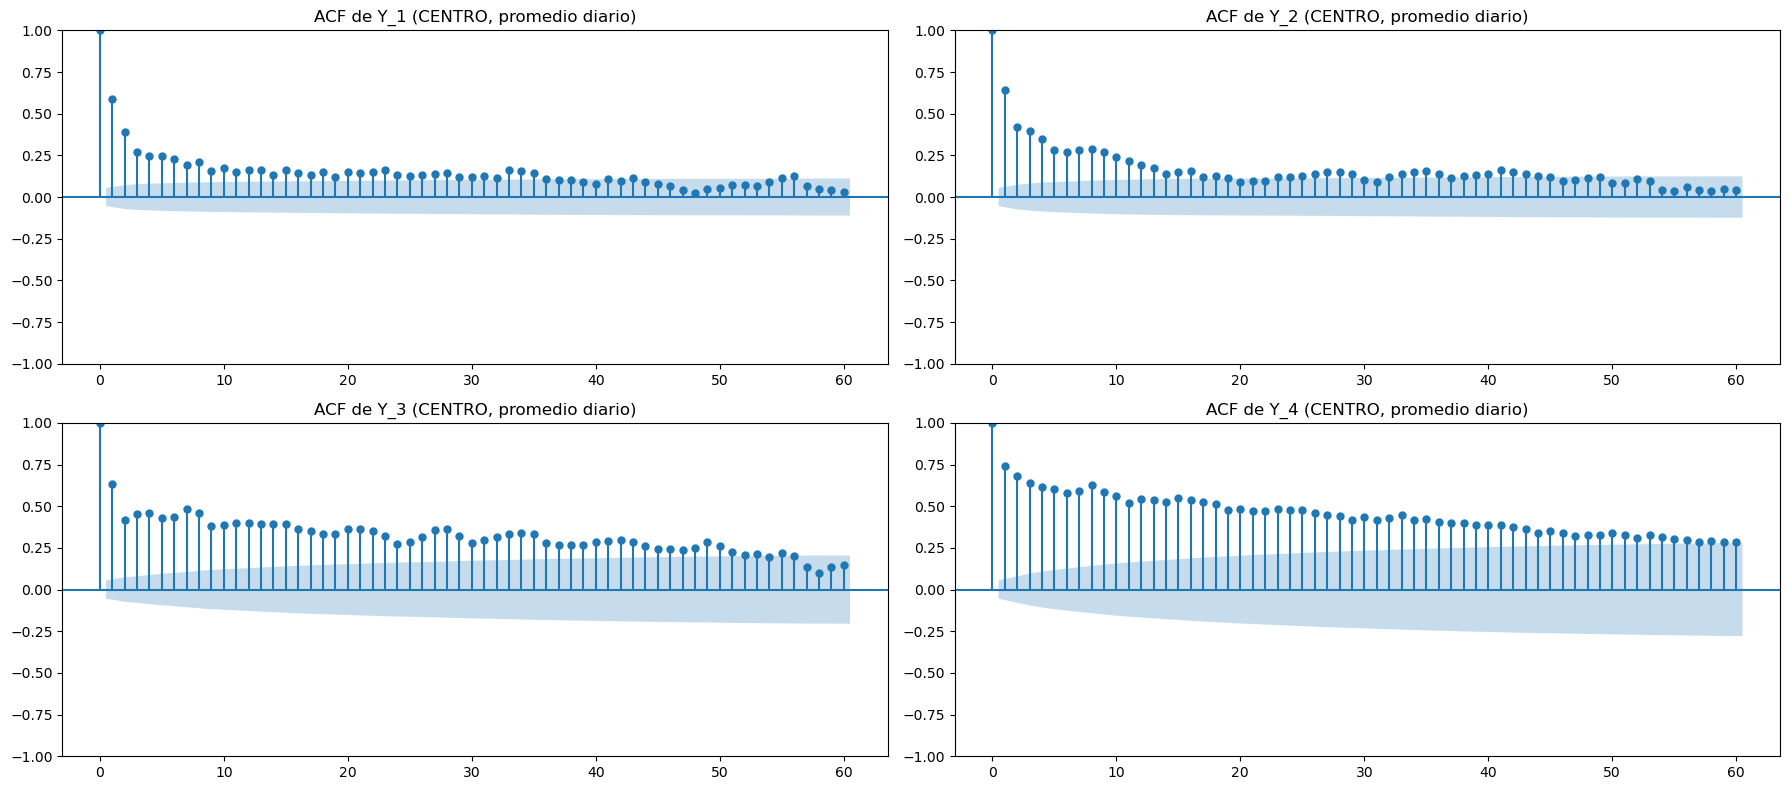

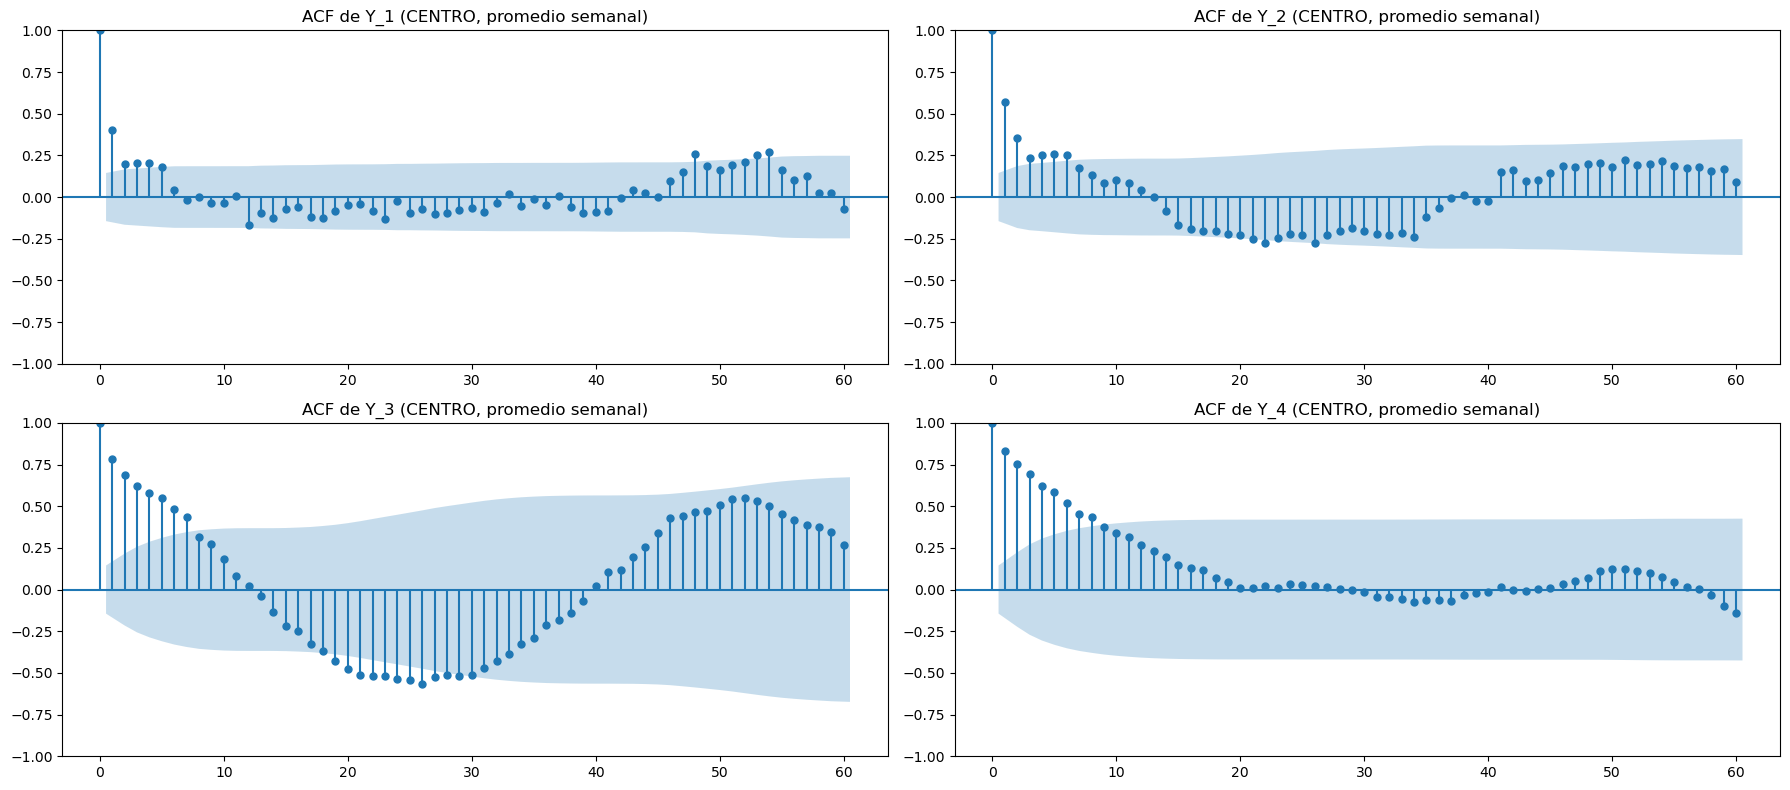

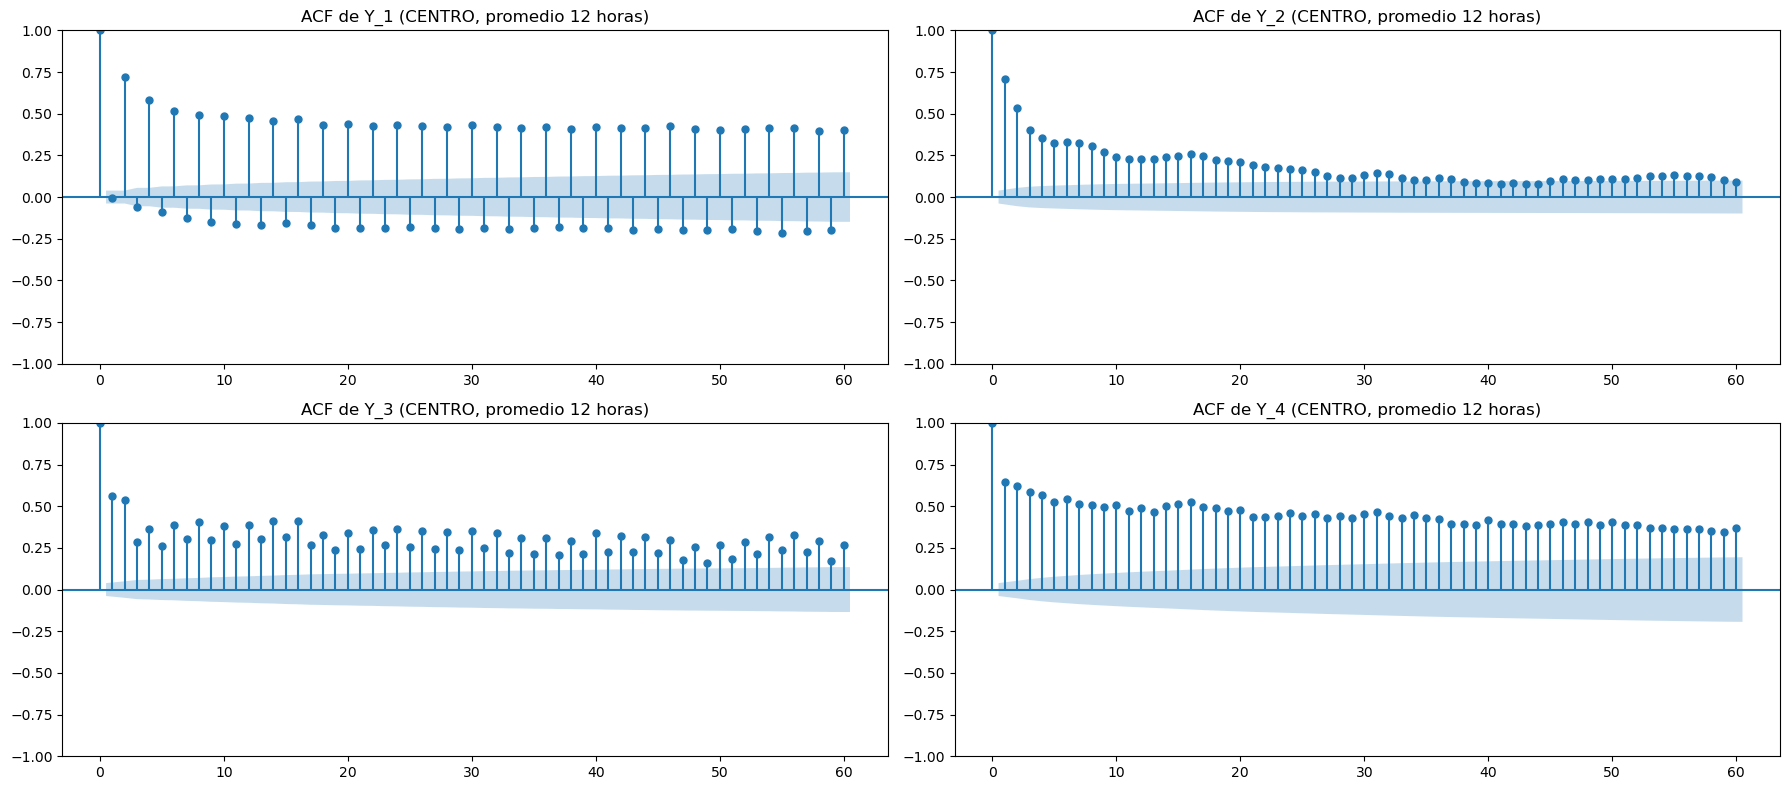

In [ ]:
variables_analizar = ["Y_1", "Y_2", "Y_3", "Y_4"]

# --- ACF diario ---
nrows, ncols = 2, 2  # 2 filas x 2 columnas
fig, axes = plt.subplots(nrows, ncols, figsize=(18, 8))
axes = axes.flatten()  # aplanar para indexado sencillo

for i, var in enumerate(variables_analizar):
    ax = axes[i]
    if var in df_Centro_diario.columns:
        serie = df_Centro_diario[var].dropna()
        plot_acf(serie, ax=ax, lags=60, alpha=0.05)
        ax.set_title(f"ACF de {var} (CENTRO, promedio diario)")
    else:
        ax.set_visible(False)

# Oculta ejes extra si hay menos variables
for j in range(len(variables_analizar), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

# --- ACF semanal ---
nrows, ncols = 2, 2  # 2 filas x 2 columnas
fig, axes = plt.subplots(nrows, ncols, figsize=(18, 8))
axes = axes.flatten()

for i, var in enumerate(variables_analizar):
    ax = axes[i]
    if var in df_Centro_semanal.columns:
        serie = df_Centro_semanal[var].dropna()
        plot_acf(serie, ax=ax, lags=60, alpha=0.05)  # lags puede ser menor porque hay menos datos semanales
        ax.set_title(f"ACF de {var} (CENTRO, promedio semanal)")
    else:
        ax.set_visible(False)

for j in range(len(variables_analizar), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


In [71]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [83]:
from itertools import product

def fit_best_sarimax(df_daily, df_weekly, contaminante):
    """
    df_daily  = dataframe con promedios diarios
    df_weekly = dataframe con promedios semanales
    contaminante = Y_1, Y_2, Y_3, Y_4
    """

    def fit_model(df, freq_label):
        """Ajusta SARIMAX para un dataframe (diario o semanal), buscando mejores hyperparametros."""

        Y = df[contaminante]
        X = df[['TOUT','RH','SR','PRS','WSR','WDR']]

        # split
        split = int(len(df)*0.8)
        Y_train, Y_test = Y.iloc[:split], Y.iloc[split:]
        X_train, X_test = X.iloc[:split], X.iloc[split:]

        # scaler sin leakage
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled  = scaler.transform(X_test)

        # buscar mejores hiperparámetros (order)
        best_aic = np.inf
        best_result = None
        best_order = None
        best_pred = None

        # rangos - p = [1,2,3], d = [0,1], q = [1,2,3]
        for order in product([1,2,3], [0,1], [1,2,3]):
            try:
                model = SARIMAX(
                    Y_train,
                    exog=X_train_scaled,
                    order=order,
                    enforce_stationarity=False,
                    enforce_invertibility=False
                )
                results = model.fit(disp=False)
                if results.aic < best_aic:
                    best_aic = results.aic
                    best_result = results
                    best_order = order
            except Exception as e:
                continue  # ignora combinaciones que no convergen, etc.

        # predicciones con mejores parámetros
        pred = best_result.predict(start=len(Y_train), end=len(Y)-1, exog=X_test_scaled)

        # métricas
        mae  = mean_absolute_error(Y_test, pred)
        rmse = np.sqrt(mean_squared_error(Y_test, pred))
        r2   = r2_score(Y_test, pred)
        # Nueva métrica: MAPE
        mape = np.mean(np.abs((Y_test - pred) / Y_test)) * 100

        # residual diagnostics
        resid = best_result.resid
        lb_p = sm.stats.acorr_ljungbox(resid, lags=[10], return_df=True)['lb_pvalue'].iloc[0]
        jb_p = sm.stats.jarque_bera(resid)[1]

        # ranking importancia
        coefs = best_result.params.filter(regex='^x')
        coef_table = pd.DataFrame({
            'Variable': X.columns,
            'Coef': coefs.values,
            'AbsImpact': np.abs(coefs.values),
            'Pvalue': best_result.pvalues.filter(regex='^x').values
        }).sort_values('AbsImpact', ascending=False)

        summary = {
            "freq": freq_label,
            "AIC": best_aic,
            "MAE": mae,
            "RMSE": rmse,
            "MAPE": mape,
            "R2": r2,
            "LjungBox_p": lb_p,
            "JarqueBera_p": jb_p,
            "coef_table": coef_table,
            "results": best_result,
            "scaler": scaler,
            "Y_test": Y_test,
            "pred": pred,
            "best_order": best_order
        }

        return summary
    
    # --- Ajustar ambos modelos ---
    daily_model  = fit_model(df_daily,  "Diario")
    weekly_model = fit_model(df_weekly, "Semanal")

    # --- Selección automática ---
    best = daily_model if daily_model["AIC"] < weekly_model["AIC"] else weekly_model

    return {
        "best_model": best,
        "daily": daily_model,
        "weekly": weekly_model
    }
    
def plot_diagnostics(result_dict):
    results = result_dict["results"]
    resid = results.resid

    # residuales
    plt.figure(figsize=(12,4))
    plt.plot(resid)
    plt.axhline(0, color="black")
    plt.title("Residuales")
    plt.show()

    # ACF / PACF
    fig, ax = plt.subplots(1,2, figsize=(14,4))
    sm.graphics.tsa.plot_acf(resid, ax=ax[0], lags=40)
    sm.graphics.tsa.plot_pacf(resid, ax=ax[1], lags=40)
    plt.show()

    # QQ plot
    sm.qqplot(resid, line='45')
    plt.title("QQ Plot")
    plt.show()

    # Hist residual
    plt.hist(resid, bins=30, edgecolor='black')
    plt.title("Histograma de residuales")
    plt.show()


/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warning

Frecuencia seleccionada: Semanal
AIC: 133.68924069325124
MAE: 0.356703788312465
RMSE: 0.4409892162462457
MAPE: 672.6381494333539
R2: 0.2215170117943085
LjungBox_p: 0.7668230968893942
JarqueBera_p: 0.07554278080143642
best_order: (2, 0, 1)
  Variable      Coef  AbsImpact        Pvalue
3      PRS -0.285698   0.285698  6.665920e-08
0     TOUT -0.275612   0.275612  1.922252e-03
4      WSR  0.128990   0.128990  2.003738e-03
1       RH -0.079623   0.079623  7.281680e-02
2       SR  0.052578   0.052578  2.830792e-01
5      WDR -0.034433   0.034433  3.565589e-01


/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


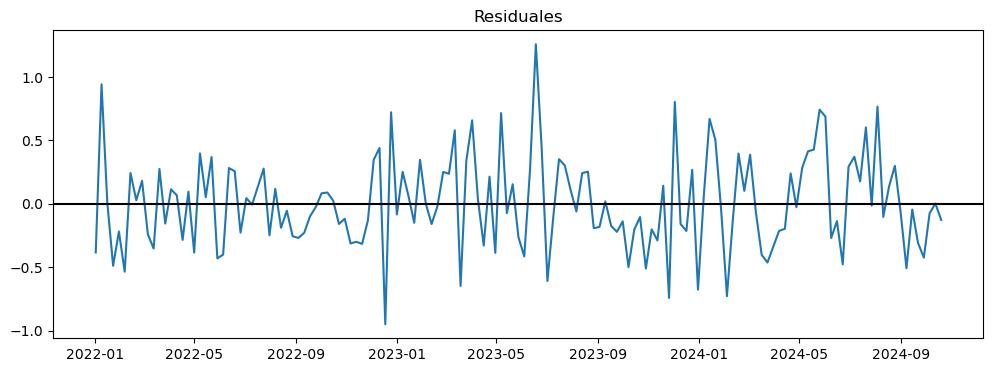

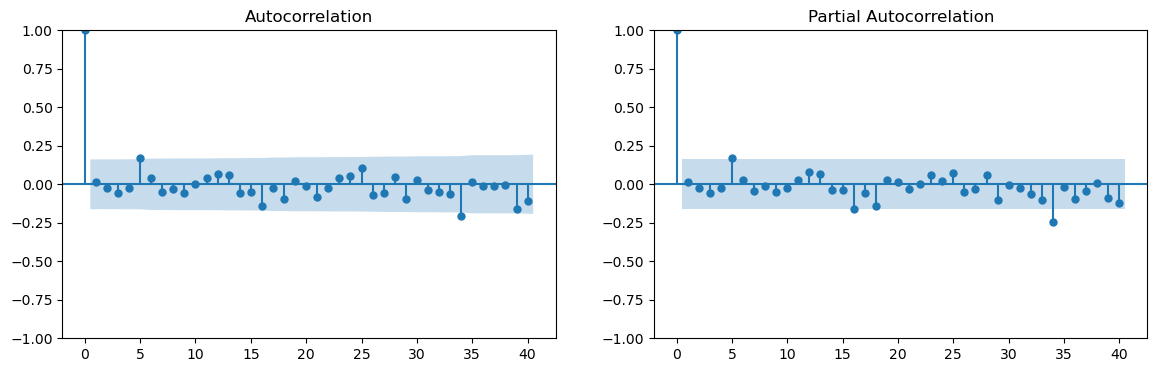

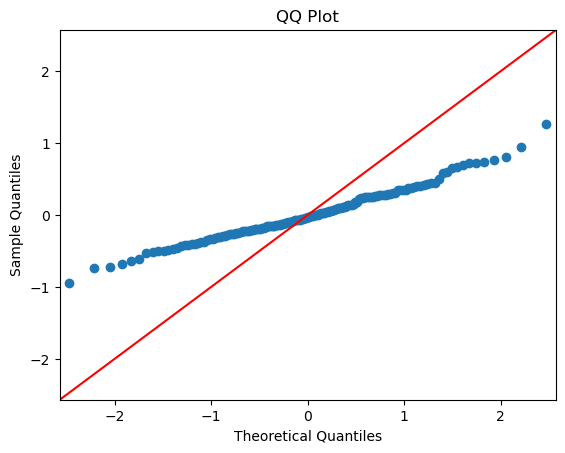

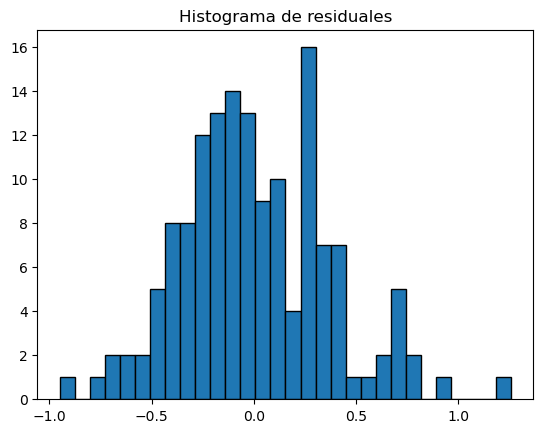

In [87]:

out = fit_best_sarimax(df_Centro_diario, df_Centro_semanal, "Y_2")

best = out["best_model"]

print("Frecuencia seleccionada:", best["freq"])
print("AIC:", best["AIC"])
print("MAE:", best["MAE"])
print("RMSE:", best["RMSE"])
print("MAPE:", best["MAPE"])
print("R2:", best["R2"])
print("LjungBox_p:", best["LjungBox_p"])
print("JarqueBera_p:", best["JarqueBera_p"])
print("best_order:", best["best_order"])
print(best["coef_table"])

plot_diagnostics(best)


In [88]:
std_dev = df_Centro_semanal['Y_2'].std()
print(f"Desviación Estándar de Y_1: {std_dev}")
print(f"Tu RMSE: 0.904")

if 0.44 < std_dev:
    print("¡El modelo FUNCIONA! Es predictivo.")
else:
    print("Cuidado: El modelo no es mejor que el promedio.")

Desviación Estándar de Y_1: 0.4975473528952898
Tu RMSE: 0.904
¡El modelo FUNCIONA! Es predictivo.


## Paso 4 - Diferenciación


Análisis de EstacionariedadObjetivo: Definir el parámetro d (diferenciación) para el modelo ARIMA.Ejecuta la Prueba Dickey-Fuller Aumentada (ADF) para $Y_1, Y_2, Y_3, Y_4$.
-   Si p < 0.05: La serie es estacionaria. $\rightarrow$ Usa $d=0$.
-   Si p > 0.05: La serie NO es estacionaria. $\rightarrow$ Aplica diferenciación (diff()). Repite prueba. Si pasa, Usa $d=1$.

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Diccionario para almacenar resultados
adf_results = {}

# Solo usar variables_analizar para el análisis
col_vars = variables_analizar

for col in col_vars:
    if col not in df_Centro_diario.columns:
        print(f"Advertencia: {col} no está en las columnas del DataFrame.")
        continue
    # Nos aseguramos de trabajar con valores float (por si acaso)
    serie = pd.to_numeric(df_Centro_diario[col], errors="coerce").dropna()
    result = adfuller(serie)
    p_value = result[1]
    adf_results[col] = {'p_value': p_value, 'diferenciaciones': 0}
    print(f"ADF resultado para {col}: p-value = {p_value:}")
    if p_value > 0.05:
        # Si no es estacionaria, diferenciamos una vez y repetimos
        serie_diff = serie.diff().dropna()
        result_diff = adfuller(serie_diff)
        p_value_diff = result_diff[1]
        adf_results[col].update({'p_value_diff': p_value_diff, 'diferenciaciones': 1})
        print(f"  Tras diferenciación: p-value = {p_value_diff}")
        if p_value_diff > 0.05:
            print(f"    ¡Atención! {col} sigue sin ser estacionaria tras una diferencia.")

# Mostrar resumen de d para cada serie
for col in col_vars:
    # Puede no estar si estaba ausente del DataFrame
    if col in adf_results:
        d = adf_results[col]['diferenciaciones']
        print(f"{col}: Se recomienda d = {d}")


ADF resultado para Y_1: p-value = 3.0728207247675327e-07
ADF resultado para Y_2: p-value = 1.3818544894449718e-09
ADF resultado para Y_3: p-value = 0.000841065661933714
ADF resultado para Y_4: p-value = 0.007794048753197938
Y_1: Se recomienda d = 0
Y_2: Se recomienda d = 0
Y_3: Se recomienda d = 0
Y_4: Se recomienda d = 0


## Paso 5 - Arimax

### Y_1 (Ozono)

In [40]:
# --- Selección automática de variables exógenas (Backward Elimination) ---

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np

meteo_cols = ["TOUT", "RH", "SR", "PRS", "WSR", "WDR"]
d = 0  # Se determinó que d=0 es suficiente para Y_1 según el ADF

# Variable dependiente (endógena)
y_ozono = df_Centro_diario["Y_1"]

# Rango de p y q a evaluar, de acuerdo a LimpiezaDatos.ipynb
p_vals = [1, 2, 3]
q_vals = [1, 2, 3]

# Estandarizar variables exógenas
scaler = StandardScaler()
X_meteo = pd.DataFrame(scaler.fit_transform(df_Centro_diario[meteo_cols]), columns=meteo_cols, index=df_Centro_diario.index)

resultados_sarimax = {}
for p in p_vals:
    for q in q_vals:
        order = (p, d, q)
        try:
            modelo_sarimax = SARIMAX(
                y_ozono,
                exog=X_meteo,
                order=order,
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            resultado = modelo_sarimax.fit(disp=False)
            aic = resultado.aic
            resultados_sarimax[(p, q)] = aic
            print(f"p={p}, q={q}, AIC={aic}")
        except Exception as e:
            resultados_sarimax[(p, q)] = None
            print(f"p={p}, q={q} falló: {e}")

# Selección del mejor modelo según el menor AIC
mejor_pq = min(
    [(pq, aic) for pq, aic in resultados_sarimax.items() if aic is not None],
    key=lambda x: x[1]
)[0]
print(f"\nMejor combinación de (p, q): {mejor_pq}")

print("\n--- Iniciando eliminación automática de variables exógenas no significativas ---")

vars_actuales = list(meteo_cols)
max_p_value = 1.0

while max_p_value > 0.05 and len(vars_actuales) > 0:

    if len(vars_actuales) > 0:
        X_subset = X_meteo[vars_actuales]
    else:
        X_subset = None

    modelo_temp = SARIMAX(
        y_ozono,
        exog=X_subset,
        order=(mejor_pq[0], d, mejor_pq[1]),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    res_temp = modelo_temp.fit(disp=False)

    # Filtrar p-values de exógenas
    pvalues_exog = res_temp.pvalues[
        [idx for idx in res_temp.pvalues.index 
         if idx not in ['ar.L1', 'ar.L2', 'ar.L3', 'ma.L1', 'ma.L2', 'ma.L3', 'sigma2']]
    ]
    
    if pvalues_exog.empty:
        break

    # Buscar la variable con mayor p-value
    worst_param = pvalues_exog.idxmax()
    max_p_value = pvalues_exog.max()

    if max_p_value > 0.05:
        var_a_eliminar = worst_param
        if var_a_eliminar in vars_actuales:
            print(f"Eliminando '{var_a_eliminar}' con p-value={max_p_value:.4f}")
            vars_actuales.remove(var_a_eliminar)
        else:
            print(f"Advertencia: No se encontró '{var_a_eliminar}' en la lista actual. P-values:\n{pvalues_exog}")
            break
    else:
        print("Todas las variables exógenas restantes son significativas.")

print(f"\nVariables finales seleccionadas: {vars_actuales}")

# --- Ajuste del Modelo Final Optimizado ---
print("\n--- Ajustando Modelo Final ---")

if vars_actuales:
    X_final = X_meteo[vars_actuales]
    modelo_final_opt = SARIMAX(
        y_ozono,
        exog=X_final,
        order=(mejor_pq[0], d, mejor_pq[1]),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
else:
    X_final = None
    modelo_final_opt = SARIMAX(
        y_ozono,
        order=(mejor_pq[0], d, mejor_pq[1]),
        enforce_stationarity=False,
        enforce_invertibility=False
    )

resultado_final_opt = modelo_final_opt.fit(disp=False)
print(resultado_final_opt.summary())

# --- Evaluación del Modelo: Métricas de eficiencia ---
print("\n--- Métricas de eficiencia del modelo ---")

# Predicción in-sample
y_pred = resultado_final_opt.fittedvalues

# Las predicciones del SARIMAX a menudo tienen el mismo índice que los datos originales, pero pueden haber valores nan al principio
mask_valid = ~np.isnan(y_pred)
y_true_valid = y_ozono[mask_valid]
y_pred_valid = y_pred[mask_valid]

mae = mean_absolute_error(y_true_valid, y_pred_valid)
mse = mean_squared_error(y_true_valid, y_pred_valid)
rmse = np.sqrt(mse)
r2 = r2_score(y_true_valid, y_pred_valid)

print(f"MAE  (Error absoluto medio): {mae:.4f}")
print(f"RMSE (Raíz del error cuadrático medio): {rmse:.4f}")
print(f"R2   (Coeficiente de determinación): {r2:.4f}")

p=1, q=1, AIC=3192.432120444404
p=1, q=2, AIC=3138.7211356001612


/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p=1, q=3, AIC=3112.776472735522


/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p=2, q=1, AIC=3119.451628221107


/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p=2, q=2, AIC=3117.63942512221


/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p=2, q=3, AIC=3119.531293793706


/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p=3, q=1, AIC=3112.1279709525406


/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p=3, q=2, AIC=3113.664200989695


/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p=3, q=3, AIC=3114.0525061243357

Mejor combinación de (p, q): (3, 1)

--- Iniciando eliminación automática de variables exógenas no significativas ---


/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Todas las variables exógenas restantes son significativas.

Variables finales seleccionadas: ['TOUT', 'RH', 'SR', 'PRS', 'WSR', 'WDR']

--- Ajustando Modelo Final ---
                               SARIMAX Results                                
Dep. Variable:                    Y_1   No. Observations:                 1277
Model:               SARIMAX(3, 0, 1)   Log Likelihood               -1545.064
Date:                Fri, 05 Dec 2025   AIC                           3112.128
Time:                        03:38:01   BIC                           3168.777
Sample:                    01-01-2022   HQIC                          3133.404
                         - 06-30-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
TOUT           0.3079      0.076      4.033

/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


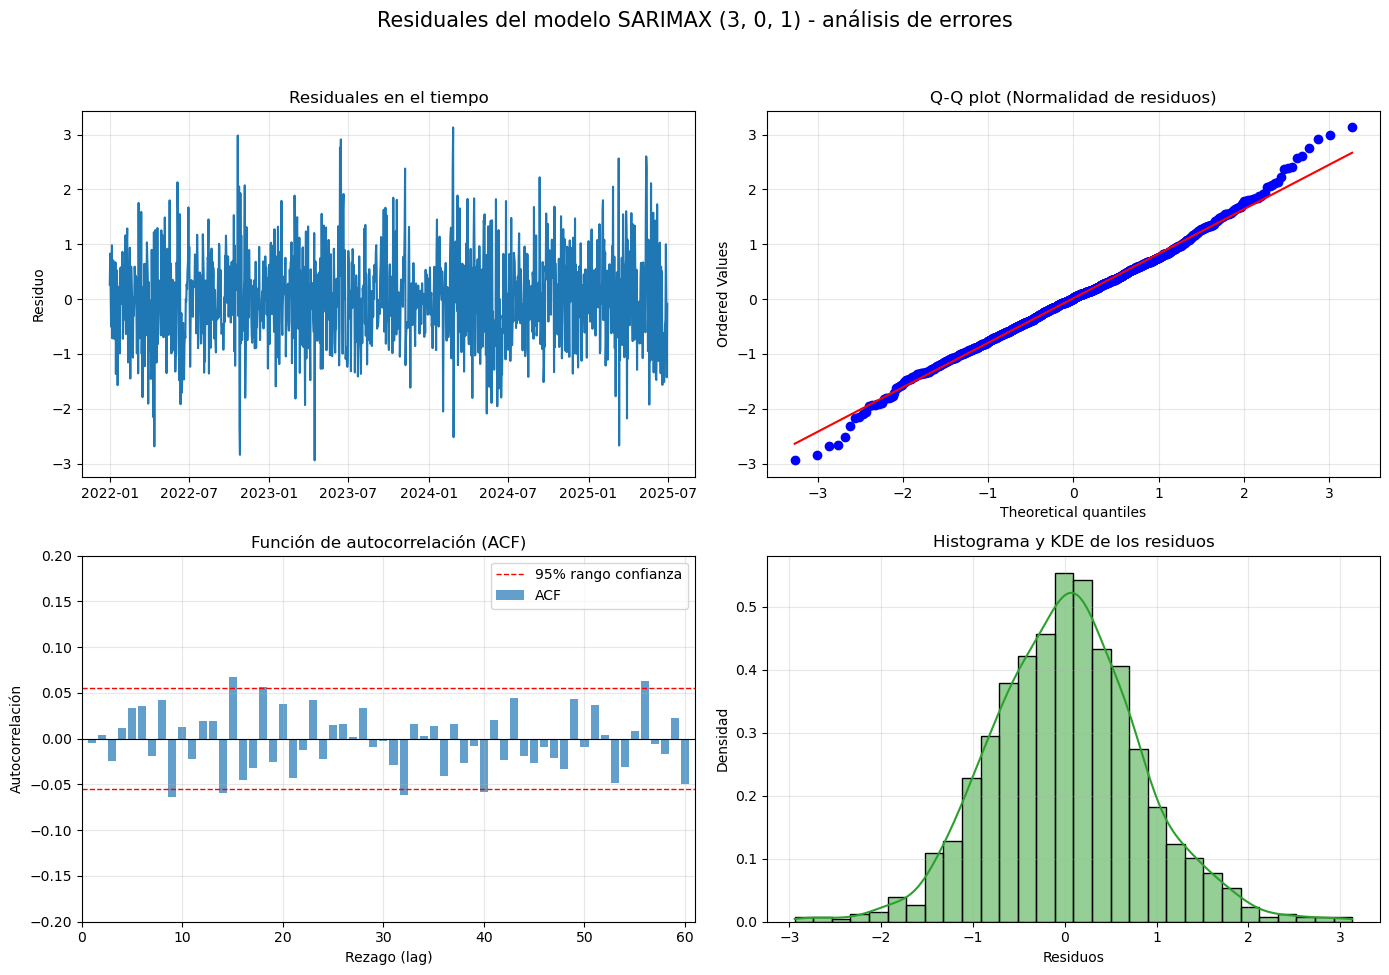

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import acf
import scipy.stats as stats
import numpy as np

# Obtener los residuos del modelo final optimizado
residuals = resultado_final_opt.resid

# Obtener los parámetros del modelo para el título
if hasattr(modelo_final_opt, "order"):
    order_str = f"{modelo_final_opt.order}"
else:
    order_str = f"({mejor_pq[0]}, {d}, {mejor_pq[1]})"

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle(f'Residuales del modelo SARIMAX {order_str} - análisis de errores', fontsize=15)

# Serie de tiempo de residuos
axes[0, 0].plot(residuals, color='tab:blue')
axes[0, 0].set_title("Residuales en el tiempo")
axes[0, 0].set_ylabel("Residuo")
axes[0, 0].grid(alpha=0.3)

# Mejor ACF plot manual para visibilidad de los rangos
max_lag = 60
acf_vals = acf(residuals.dropna(), nlags=max_lag, fft=True)
n_obs = residuals.dropna().shape[0]
confint_95 = 1.96 / np.sqrt(n_obs)

lags = np.arange(1, max_lag + 1)

axes[1, 0].bar(lags, acf_vals[1:], color='tab:blue', alpha=0.7, width=0.8, align='center', label="ACF")
axes[1, 0].axhline(y=0, color="black", linewidth=0.8)
axes[1, 0].axhline(y=confint_95, color="red", linestyle="--", linewidth=1, label="95% rango confianza")
axes[1, 0].axhline(y=-confint_95, color="red", linestyle="--", linewidth=1)
axes[1, 0].set_title("Función de autocorrelación (ACF)")
axes[1, 0].set_xlabel("Rezago (lag)")
axes[1, 0].set_ylabel("Autocorrelación")
axes[1, 0].set_xlim(0, max_lag + 1)
axes[1, 0].set_ylim(min(-0.2, acf_vals[1:].min()-0.05), max(0.2, acf_vals[1:].max()+0.05))
axes[1, 0].grid(alpha=0.3)
axes[1, 0].legend(loc='upper right')

# Histograma + kde
sns.histplot(residuals.dropna(), kde=True, ax=axes[1, 1], stat='density', bins=30, color='tab:green')
axes[1, 1].set_title("Histograma y KDE de los residuos")
axes[1, 1].set_xlabel("Residuos")
axes[1, 1].set_ylabel("Densidad")
axes[1, 1].grid(alpha=0.3)

# QQ plot
stats.probplot(residuals.dropna(), dist="norm", plot=axes[0, 1])
axes[0, 1].set_title("Q-Q plot (Normalidad de residuos)")
axes[0, 1].grid(alpha=0.3)

plt.tight_layout(rect=[0, 0.01, 1, 0.95])
plt.show()

In [70]:

from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

#seleccionar la variable objetivo y las exogenas
Y = df_Centro_diario["Y_1"]      # o el contaminante actual
X = df_Centro_diario[["TOUT","RH","SR","PRS","WSR","WDR"]]

#dividir en entrenamiento y prueba
split = int(len(df_Centro_diario) * 0.8)
Y_train, Y_test = Y[:split], Y[split:]
X_train, X_test = X[:split], X[split:]

#escalar las variables exogenas
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

#ajustar el modelo
order = (3,0,1)

model = SARIMAX(
    Y_train,
    exog=X_train_scaled,
    order=order,
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit(disp=False)
print(results.summary())

#predecir
pred = results.predict(start=len(Y_train), end=len(Y)-1, exog=X_test_scaled)

#calcular métricas
mae  = mean_absolute_error(Y_test, pred)
rmse = np.sqrt(mean_squared_error(Y_test, pred))
r2   = r2_score(Y_test, pred)

print("MAE :", mae)
print("RMSE:", rmse)
print("R2  :", r2)



                               SARIMAX Results                                
Dep. Variable:                    Y_1   No. Observations:                 1021
Model:               SARIMAX(3, 0, 1)   Log Likelihood               -1219.673
Date:                Fri, 05 Dec 2025   AIC                           2461.346
Time:                        04:38:14   BIC                           2515.528
Sample:                    01-01-2022   HQIC                          2481.921
                         - 10-17-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.3578      0.085      4.234      0.000       0.192       0.523
x2            -0.0936      0.045     -2.070      0.038      -0.182      -0.005
x3             0.4275      0.049      8.696      0.0

/Users/gabrielvas/miniforge3/envs/data_science_arm64/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Y_2 (Partículas)

                                     SARIMAX Results                                     
Dep. Variable:                               Y_2   No. Observations:                 1021
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood                -649.899
Date:                           Fri, 05 Dec 2025   AIC                           1321.798
Time:                                   04:15:16   BIC                           1375.914
Sample:                               01-01-2022   HQIC                          1342.354
                                    - 10-17-2024                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
TOUT           0.1275      0.040      3.182      0.001       0.049       0.206
RH             0.0481      0.022      2.138

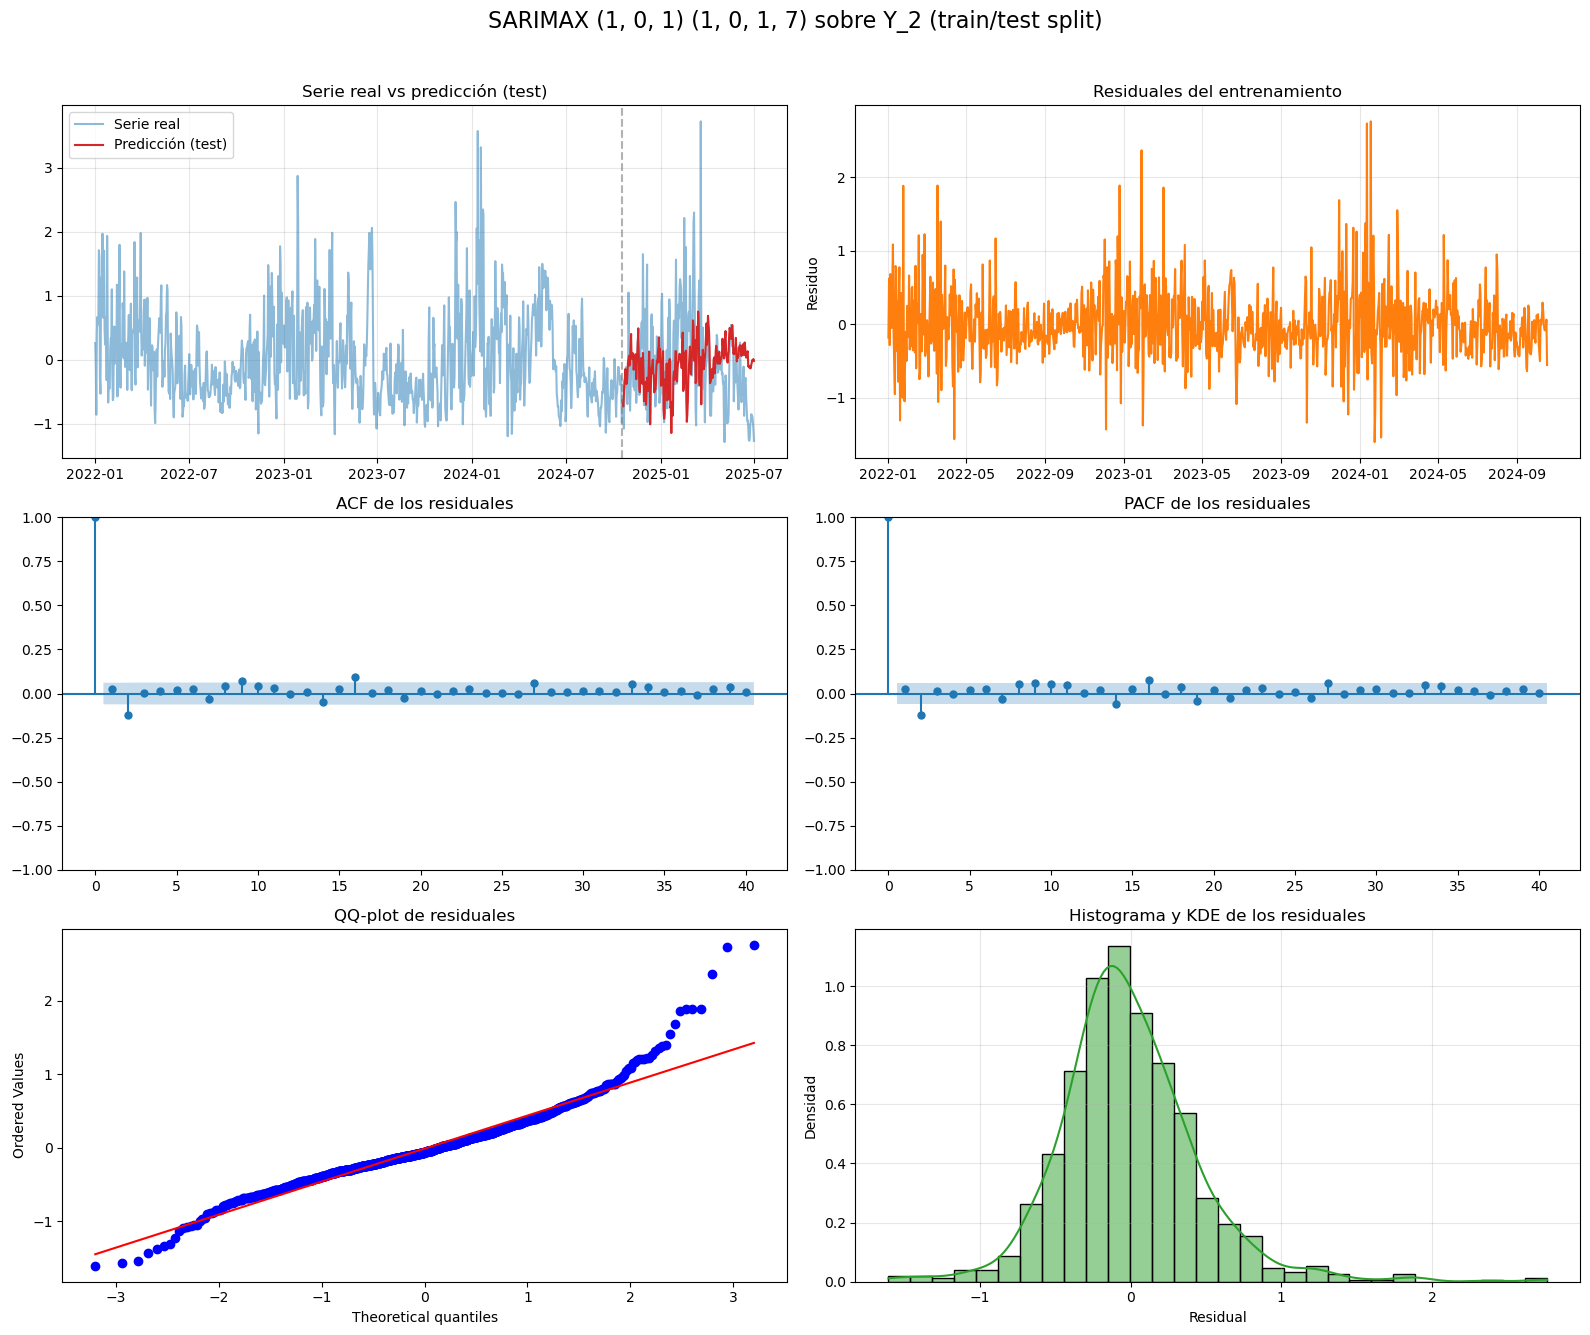


--- Métricas en TEST ---
MAE  (Error absoluto medio): 0.5269
RMSE (Raíz del error cuadrático medio): 0.7002
R2   (Coeficiente de determinación): -0.0084


In [61]:
# --- Selección automática de variables exógenas (Backward Elimination) ---
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import scipy.stats as stats

# --- Separar variable objetivo y exógenas ---
target_col = "Y_2"
exog_cols = ["TOUT", "RH", "SR", "PRS", "WSR", "WDR"]

y = df_Centro_diario[target_col].copy()
X = df_Centro_diario[exog_cols].copy()

# --- Estandarizar las variables exógenas ---
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

# --- División en entrenamiento y prueba ---
# Usamos 80% entrenamiento, 20% prueba (puede cambiar según necesidad)
split_frac = 0.8
split_idx = int(len(df_Centro_diario) * split_frac)

y_train = y.iloc[:split_idx]
X_train = X_scaled.iloc[:split_idx]
y_test = y.iloc[split_idx:]
X_test = X_scaled.iloc[split_idx:]

# --- Definir parámetros SARIMAX (pueden ajustarse según búsqueda previa) ---
# (p,d,q) = (1,0,1); (P,D,Q,s) estacional: (1,0,1,7) (supongamos semanalidad diaria)
order = (1, 0, 1)
seasonal_order = (1, 0, 1, 7)

# --- Ajustar el modelo ---
model = SARIMAX(
    y_train,
    exog=X_train,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)
results = model.fit(disp=False)
print(results.summary())

# --- Predicciones en prueba ---
# Nota: SARIMAX necesita los exógenos para predicción
y_pred_test = results.predict(
    start=y_test.index[0], 
    end=y_test.index[-1], 
    exog=X_test
)

# --- Análisis de residuales ---
# Residuales de entrenamiento (fit)
residuals = results.resid

# --- Gráficas requeridas ---
fig, axes = plt.subplots(3, 2, figsize=(16, 14))
fig.suptitle(f"SARIMAX {order} {seasonal_order} sobre Y_2 (train/test split)", fontsize=16)

# [0,0]: Serie real vs predicha (solo prueba)
axes[0, 0].plot(y, label="Serie real", color="tab:blue", alpha=0.5)
axes[0, 0].plot(y_pred_test, label="Predicción (test)", color="tab:red")
axes[0, 0].axvline(y_test.index[0], color="gray", linestyle="--", alpha=0.6)
axes[0, 0].set_title("Serie real vs predicción (test)")
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# [0,1]: Residuales (entrenamiento)
axes[0, 1].plot(residuals, color='tab:orange')
axes[0, 1].set_title("Residuales del entrenamiento")
axes[0, 1].set_ylabel("Residuo")
axes[0, 1].grid(alpha=0.3)

# [1,0]: ACF de residuales (entrenamiento)
plot_acf(residuals.dropna(), lags=40, ax=axes[1,0])
axes[1,0].set_title("ACF de los residuales")

# [1,1]: PACF de residuales (entrenamiento)
plot_pacf(residuals.dropna(), lags=40, ax=axes[1,1], method="ywm")
axes[1,1].set_title("PACF de los residuales")

# [2,0]: QQ plot de residuales (entrenamiento)
stats.probplot(residuals.dropna(), dist="norm", plot=axes[2, 0])
axes[2,0].set_title("QQ-plot de residuales")

# [2,1]: Histograma + KDE de residuales (entrenamiento)
sns.histplot(residuals.dropna(), kde=True, bins=30, ax=axes[2, 1], color='tab:green', stat='density')
axes[2,1].set_title("Histograma y KDE de los residuales")
axes[2,1].set_xlabel("Residual")
axes[2,1].set_ylabel("Densidad")
axes[2,1].grid(alpha=0.3)

plt.tight_layout(rect=[0, 0.03, 1, 0.965])
plt.show()

# --- Métricas de eficiencia en test ---
# Solo sobre el periodo de test
mask_valid = ~np.isnan(y_pred_test)
y_true_valid = y_test[mask_valid]
y_pred_valid = y_pred_test[mask_valid]

mae = mean_absolute_error(y_true_valid, y_pred_valid)
mse = mean_squared_error(y_true_valid, y_pred_valid)
rmse = np.sqrt(mse)
r2 = r2_score(y_true_valid, y_pred_valid)

print("\n--- Métricas en TEST ---")
print(f"MAE  (Error absoluto medio): {mae:.4f}")
print(f"RMSE (Raíz del error cuadrático medio): {rmse:.4f}")
print(f"R2   (Coeficiente de determinación): {r2:.4f}")


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import acf
import scipy.stats as stats
import numpy as np

# Obtener los residuos del modelo final optimizado
residuals = resultado_final_opt.resid

# Obtener los parámetros del modelo para el título
if hasattr(modelo_final_opt, "order"):
    order_str = f"{modelo_final_opt.order}"
else:
    order_str = f"({mejor_pq[0]}, {d}, {mejor_pq[1]})"

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle(f'Residuales del modelo SARIMAX {order_str} - análisis de errores', fontsize=15)

# Serie de tiempo de residuos
axes[0, 0].plot(residuals, color='tab:blue')
axes[0, 0].set_title("Residuales en el tiempo")
axes[0, 0].set_ylabel("Residuo")
axes[0, 0].grid(alpha=0.3)

# Mejor ACF plot manual para visibilidad de los rangos
max_lag = 60
acf_vals = acf(residuals.dropna(), nlags=max_lag, fft=True)
n_obs = residuals.dropna().shape[0]
confint_95 = 1.96 / np.sqrt(n_obs)

lags = np.arange(1, max_lag + 1)

axes[1, 0].bar(lags, acf_vals[1:], color='tab:blue', alpha=0.7, width=0.8, align='center', label="ACF")
axes[1, 0].axhline(y=0, color="black", linewidth=0.8)
axes[1, 0].axhline(y=confint_95, color="red", linestyle="--", linewidth=1, label="95% rango confianza")
axes[1, 0].axhline(y=-confint_95, color="red", linestyle="--", linewidth=1)
axes[1, 0].set_title("Función de autocorrelación (ACF)")
axes[1, 0].set_xlabel("Rezago (lag)")
axes[1, 0].set_ylabel("Autocorrelación")
axes[1, 0].set_xlim(0, max_lag + 1)
axes[1, 0].set_ylim(min(-0.2, acf_vals[1:].min()-0.05), max(0.2, acf_vals[1:].max()+0.05))
axes[1, 0].grid(alpha=0.3)
axes[1, 0].legend(loc='upper right')

# Histograma + kde
sns.histplot(residuals.dropna(), kde=True, ax=axes[1, 1], stat='density', bins=30, color='tab:green')
axes[1, 1].set_title("Histograma y KDE de los residuos")
axes[1, 1].set_xlabel("Residuos")
axes[1, 1].set_ylabel("Densidad")
axes[1, 1].grid(alpha=0.3)

# QQ plot
stats.probplot(residuals.dropna(), dist="norm", plot=axes[0, 1])
axes[0, 1].set_title("Q-Q plot (Normalidad de residuos)")
axes[0, 1].grid(alpha=0.3)

plt.tight_layout(rect=[0, 0.01, 1, 0.95])
plt.show()

### Y_3 (Nitrógenos)

### Y_4 (SO2)